# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [4]:
import os 

In [5]:
role = get_execution_role()
bucket='project-dog-breeds'

In [6]:
from io import BytesIO
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
        CategoricalParameter, 
        ContinuousParameter, 
        HyperparameterTuner, 
        IntegerParameter
)

hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64, 128, 256])
}

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'average test loss', 'Regex': 'Test Average Loss: ([0-9\\.]+)'}]

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point = 'hpo.py',
    base_job_name = 'dog-breed-classification-hyperparameter',
    role = role,
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge',
    framework_version = '1.9',
    py_version = 'py38'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type=objective_type,
    max_jobs=4,
    max_parallel_jobs=1
)   

In [9]:
data_path = f's3://{bucket}/dogImages/'
data_path

's3://project-dog-breeds/dogImages/'

In [10]:
data_path_mini = f's3://{bucket}/dogImages-mini/'
data_path_short = f's3://{bucket}/dogImages-short/'

In [11]:
# TODO: Fit your HP Tuner
#tuner.fit({'train': data_path}, wait=True) # TODO: Remember to include your data channels

In [12]:
# TODO: Get the best estimators and the best HPs

#best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
#best_estimator.hyperparameters()

In [13]:
best_hyperparameters = {'batch_size': 256, 'learning_rate': 0.03620856736835261}

In [14]:
#tuner.best_training_job()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
best_hyperparameters_reduced_batch_size = {'batch_size': 64, 'learning_rate': 0.03620856736835261}

In [16]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule, 
    rule_configs, 
    ProfilerRule, 
    DebuggerHookConfig, 
    CollectionConfig, 
    ProfilerConfig, 
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

# collection of parameters. collection saved at s3://course4-project/dog-breeds/hook.
collection_config_biases = CollectionConfig(name='biases')
collection_config_weights = CollectionConfig(name='weights')
collection_config_losses = CollectionConfig(name='losses')

# debugger_hook_config = DebuggerHookConfig(
#     s3_output_path=f"s3://{bucket}/dog-breeds/hook",
#     hook_parameters={
#         'save_interval': '100'
#     },
#     collection_configs=[
#         collection_config_biases,
#         collection_config_weights,
#         collection_config_losses
#     ]
# )

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
# debugger_hook_config = DebuggerHookConfig(
#     hook_parameters={
#         "train.save_interval": "10",
#         "eval.save_interval": "1"
#     }
# )

In [18]:
collection_config = [CollectionConfig(
                                    name="losses",
                                    parameters={"include_regex": "Test Average Loss",
                                                "train.save_interval": "10",
                                                "eval.save_interval": "1"})
                        ]
    
debugger_hook_config = DebuggerHookConfig(collection_configs = collection_config)

In [19]:
# TODO: Create and fit an estimator

estimator = PyTorch( 
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    base_job_name='debugger-dog-breeds-job',
    instance_type='ml.p2.xlarge', 
    framework_version='1.9',
    py_version='py38',
    hyperparameters=best_hyperparameters_reduced_batch_size,
    metric_definitions=metric_definitions,
    rules = rules,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_hook_config
)

In [20]:
estimator.fit({'train': data_path}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: debugger-dog-breeds-job-2024-11-20-22-14-09-147


2024-11-20 22:14:12 Starting - Starting the training job...
2024-11-20 22:14:40 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2024-11-20 22:15:40 Downloading - Downloading input data......
2024-11-20 22:16:41 Downloading - Downloading the training image..............................
2024-11-20 22:21:46 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-20 22:22:04,810 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-20 22:22:04,844 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-20 22:22:04,848 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-11-20 22:22:05,212 sagemaker-trai

In [22]:
# # Get training job first logs 
# client = boto3.client('logs')
# response = client.get_log_events(
#     logGroupName='/aws/sagemaker/TrainingJobs',
#     logStreamName='debugger-dog-breeds-job-2024-11-20-18-45-57-303/algo-1-1732128431',
# #    startTime=int((datetime.today() - timedelta(hours=5)).timestamp()),
# #    endTime=int(datetime.now().timestamp()),
# #    nextToken='string',
#     limit=115,
#     startFromHead=True,
# )

In [24]:
# log_events = response['events']
# for each_event in log_events:
#     print(each_event['message'])

In [25]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : debugger-dog-breeds-job-2024-11-20-22-14-09-147

latest_job_debugger_artifacts_path : s3://sagemaker-us-east-1-339840815706/debugger-dog-breeds-job-2024-11-20-22-14-09-147/debug-output

rule_output_path : s3://sagemaker-us-east-1-339840815706/debugger-dog-breeds-job-2024-11-20-22-14-09-147/rule-output



In [26]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-11-20 22:29:19.998 default:126 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-20 22:29:20.016 default:126 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-339840815706/debugger-dog-breeds-job-2024-11-20-22-14-09-147/debug-output


In [ ]:
#trial.tensor_names()

In [ ]:
#trial.tensor('cross_entropy_loss_output_0').values()

In [28]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

[2024-11-20 22:29:39.759 default:126 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-20 22:29:40.784 default:126 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


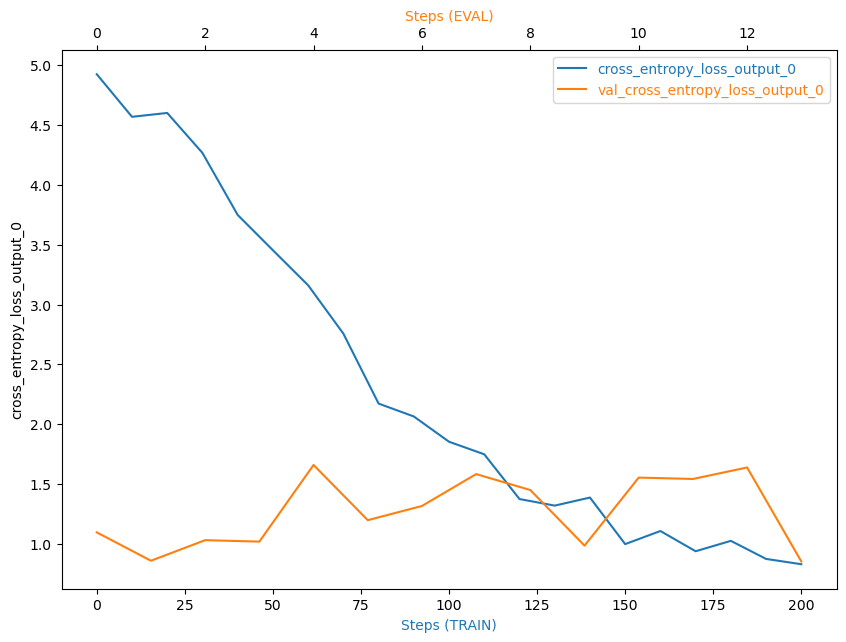

In [29]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "cross_entropy_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [30]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-339840815706/debugger-dog-breeds-job-2024-11-20-22-14-09-147/output/model.tar.gz'

In [31]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

In [37]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [42]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [43]:
# TODO: Deploy your model to an endpoint

predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium',
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-339840815706/debugger-dog-breeds-job-2024-11-20-22-14-09-147/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-339840815706/pytorch-inference-2024-11-20-22-55-22-639/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-11-20-22-55-30-786
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-11-20-22-55-31-507
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-11-20-22-55-31-507


----------------!

In [44]:
# TODO: Run an prediction on the endpoint
test_dir = './data/test/'
test_images = ['Maltese_06716.jpg', 'Maltese_06718.jpg', 'Maltese_06728.jpg', 'Maltese_06754.jpg', 'Maltese_06757.jpg', 'Maltese_06766.jpg']
test_image = test_images[0]
image = os.path.join(test_dir, test_image) 

In [45]:
response = predictor.predict(image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-11-20-22-55-31-507 in account 339840815706 for more information.

In [ ]:
# from PIL import Image
# img = Image.open(image)
# img.show()

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()